In [23]:
import numpy as np
import tensorflow as tf
import spektral
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.optimizers import Adam, SGD
from spektral.datasets import TUDataset
from spektral.models import GeneralGNN
from spektral.data import Dataset, DisjointLoader, Graph, BatchLoader
from spektral.layers import GCSConv, GlobalAvgPool, GCNConv, GlobalSumPool, MinCutPool, MessagePassing
from spektral.layers.pooling import TopKPool
import networkx as nx
import pandas as pd
import pickle
import glob
from tqdm import tqdm

In [24]:
# Load in label by name
def get_label(file, labels):
    pair_1 = file.split('/')[-1]
    pair_1, pair_2 = pair_1.split("and")
    pair_1 = pair_1.replace(".gpickle", "")
    pair_2 = pair_2.replace(".gpickle", "")
    l = int(labels.loc[(labels.protein_1 == pair_1) & (labels.protein_2 == pair_2)].label)
    return file, l

def binary_acc(y_pred, y_test):
    probas = torch.sigmoid(y_pred)
    y_pred_tag = torch.round(torch.sigmoid(y_pred))
    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc, y_pred_tag, probas


class MyDataset(Dataset):
    """
    A dataset generator fpr protein bi-molecular graphs.
    The task is to classify whether or not the proteins are physically interacting.
    """

    def __init__(self, n_samples=100, labels=[1], **kwargs):
        for name, value in kwargs.items():
            setattr(self, name, value)
            
        # Define custom attributes here
        self.n_samples = n_samples
        self.labels=labels
        super().__init__(**kwargs)
    
    # Nested read function
    def read(self):
        """ This method will be called n=n_sample times.
            Generates a list of graphs by calling make_graph()."""
            
        def make_graph(idx=0):
            """ Responsible for generating a single graph observation."""
            # Load Graphs (G) from files
            y = self.labels[idx]
            G = self.read_graph(self.files[idx])
            G = self.format_graph(G)
            SG = self.generate_spektral_graph(graph=G, label=y)
            return SG

        # We must return a list of Graph objects
        return [make_graph(idx=idx) for idx in range(self.n_samples)]

    def get_adjacency(self, graph, to_sparse=True):
        """Retrieves the adjacency matrix for a single graph    

        :param graphs: networkx graph object
        :type graphs: nx graph  
        :return: adjacency matrix of graph
        :rtype: numyp dense array
        """
        if to_sparse:
            a = coo_matrix(nx.adjacency_matrix(graph))
        else:
            a = nx.adjacency_matrix(graph)
        return a

    def get_node_features(self, graph, feature_name='x'):
        """Grabs all node features of a graph

        :param graph: nx graph object
        :type graph: nx object
        :param feature_name: name of the feature, defaults to 'x'
        :type feature_name: str, optional
        :return: collection of node features
        :rtype: numpy array of shape: (n_nodes, n_features)
        """
        return np.vstack([x[1] for x in graph.nodes.data(feature_name)])

    def get_edge_features(self, graph, to_sparse=True):
        """Grabs all edge features of a graph

        :param graph: nx graph object
        :type graph: nx object
        :return: collection of edge features
        :rtype: numpy array of shape (n_edges, n_features)
        """
        features = []
        edge_features = [x[2] for x in list(graph.edges(data=True))]
        edge_feature_names = list(edge_features[0].keys())

        for nfn in edge_feature_names:
            x = [feature[nfn] for feature in edge_features]
            features.append(x)
        features = np.array(features).T

        if to_sparse:
            x = coo_matrix(features)
        else:
            x = features
        return x

    def get_spektral_graph(self, x, e, a, y):
        return Graph(x=x, a=a, y=y)

    def generate_spektral_graph(self, graph, label):
        # Graphs must be a collection of nx.graph obejects > 1 
        adjacency_matrix = self.get_adjacency(graph, to_sparse=False)
        edge_features = self.get_edge_features(graph, to_sparse=False)
        node_features = self.get_node_features(graph, feature_name='x')
        graph_labels = np.array(label)
        SG = self.get_spektral_graph(x=node_features, e=edge_features, a=adjacency_matrix, y=graph_labels)
        return SG

    def read_graph(self, file):
        G = nx.read_gpickle(file)
        return G
        
    def format_graph(self, graph):
        # Convert str names to ints
        F = nx.convert_node_labels_to_integers(graph)
        # nx default addition edge name - undesirbale
        att = 'weight' 
        for (n1, n2, d) in F.edges(data=True):
            if att in d:
                # To clear specific edge data
                d.pop(att, None) 
        return F



In [25]:
def get_adjacency(graph, to_sparse=True):
    """Retrieves the adjacency matrix for a single graph    

    :param graphs: networkx graph object
    :type graphs: nx graph  
    :return: adjacency matrix of graph
    :rtype: numyp dense array
    """
    if to_sparse:
        a = coo_matrix(nx.adjacency_matrix(graph))
    else:
        a = nx.adjacency_matrix(graph).todense()
    return a

def get_node_features(graph, feature_name='x'):
    """Grabs all node features of a graph

    :param graph: nx graph object
    :type graph: nx object
    :param feature_name: name of the feature, defaults to 'x'
    :type feature_name: str, optional
    :return: collection of node features
    :rtype: numpy array of shape: (n_nodes, n_features)
    """
    return np.vstack([x[1] for x in graph.nodes.data(feature_name)])

def get_edge_features(graph, to_sparse=True):
    """Grabs all edge features of a graph

    :param graph: nx graph object
    :type graph: nx object
    :return: collection of edge features
    :rtype: numpy array of shape (n_edges, n_features)
    """
    features = []
    edge_features = [x[2] for x in list(graph.edges(data=True))]
    edge_feature_names = list(edge_features[0].keys())

    for nfn in edge_feature_names:
        x = [feature[nfn] for feature in edge_features]
        features.append(x)
    features = np.array(features).T
    if to_sparse:
        x = coo_matrix(features)
    else:
        x = features
    return x

def get_spektral_graph(x, e, a, y):
    return Graph(x=x, a=a, e=e, y=y)

def generate_spektral_graphs(graphs, label):
    l = []
    with tqdm(len(graphs)) as pbar:
        for graph in graphs:
            # Graphs must be a collection of nx.graph obejects > 1 
            adjacency_matrix = get_adjacency(graph, to_sparse=False)
            edge_features = get_edge_features(graph, to_sparse=False)
            node_features = get_node_features(graph, feature_name='x')
            SG = get_spektral_graph(x=node_features, e=edge_features, a=adjacency_matrix, y=label)
            l.append(SG)
            pbar.update(1)
        return l

# Load in label by name
def get_label(file, labels):
    pair_1 = file.split('/')[-1]
    pair_1, pair_2 = pair_1.split("and")
    pair_1 = pair_1.replace(".gpickle", "")
    pair_2 = pair_2.replace(".gpickle", "")
    l = int(labels.loc[(labels.protein_1 == pair_1) & (labels.protein_2 == pair_2)].label)
    return file, l

def read_graphs(graphs):
    l = []
    with tqdm(len(graphs)) as pbar:
        for graph in graphs:
            G = nx.read_gpickle(graph)
            l.append(G)
            pbar.update(1)
        return l

def format_graphs(graphs):
    l = []
    with tqdm(len(graphs)) as pbar:
        for graph in graphs:
            # Convert into pytorch geoetric dataset
            F = nx.convert_node_labels_to_integers(graph)
            # nx default addition edge name - undesirbale
            att = 'weight' 
            for (n1, n2, d) in F.edges(data=True):
                if att in d:
                    # To clear specific edge data
                    d.pop(att, None) 
            l.append(F)
            pbar.update(1)
        return l

In [26]:
# Import the data
graph_dir_path = '/mnt/mnemo5/sum02dean/sl_projects/GCN/GCN-STRING/src/scripts/dca_graph_data'
labels_dir_path = '/mnt/mnemo5/sum02dean/sl_projects/GCN/GCN-STRING/src/scripts/dca_graph_labels'

graph_files = glob.glob(os.path.join(graph_dir_path, '*'))
graph_labels = glob.glob(os.path.join(labels_dir_path, '*'))
graph_labels = pd.read_csv(graph_labels[0])

# Create positive and negative sets
positives = []
pos_labels = []

negatives = []
neg_labels = []

for i, file in enumerate(graph_files):
    obs, label = get_label(file, graph_labels)
    
    if label == 1:
        positives.append(obs)
        pos_labels.append([1, 0])
    else:
        negatives.append(obs)
        neg_labels.append([0, 1])

In [27]:
# Balance the number of negatives with number of positives
import random
negatives = random.sample(negatives, len(positives))
neg_labels = random.sample(neg_labels, len(positives))

assert(len(positives)==len(negatives))
assert(len(pos_labels)==len(neg_labels))

In [28]:
pos_graphs = read_graphs(positives)
neg_graphs = read_graphs(negatives)


5417it [00:32, 165.06it/s]
5417it [00:42, 126.11it/s]


In [29]:
pos_graphs = format_graphs(pos_graphs)
neg_graphs = format_graphs(neg_graphs)

5417it [01:06, 81.81it/s] 
5417it [01:22, 65.76it/s]


In [30]:
sg_pos = generate_spektral_graphs(pos_graphs, 1.0)
sg_neg = generate_spektral_graphs(neg_graphs, 0.0)


0it [00:00, ?it/s]/tmp/ipykernel_3113359/3111498262.py:12: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  a = nx.adjacency_matrix(graph).todense()
5417it [03:07, 28.93it/s] 
5417it [04:08, 21.82it/s]


In [31]:
balanced_graphs = positives + negatives
class_labels = pos_labels + neg_labels

In [32]:
# This part takes a very long time
samples = len(balanced_graphs)
dataset = MyDataset(files=balanced_graphs, labels=class_labels, n_samples=samples)


/tmp/ipykernel_3113359/510047211.py:62: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  a = nx.adjacency_matrix(graph)


In [33]:
# Split into train and test
train_idx = np.random.choice(a=[False, True], size=len(balanced_graphs))
val_idx = ~train_idx

# Convert range to array 
full_idx = np.array(range(len(balanced_graphs)))

# Grab indices using Boolean array
tr_idx = full_idx[train_idx]
te_idx = full_idx[val_idx]

# Slice train and test data
data_tr = dataset[tr_idx]
data_te = dataset[te_idx]

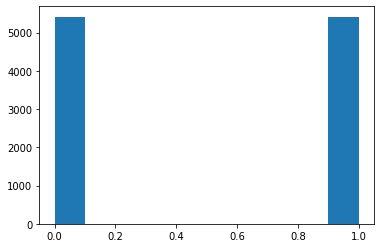

In [34]:
import matplotlib.pyplot as plt
plt.hist([x.y[0] for x in dataset])
plt.show()

In [37]:
batch_size = 50
learning_rate = 0.0002
epochs = 50
weights = []
performance = []
n_labels = 2

checkpoint_filepath = 'checkpoint/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


# Data loaders
loader_tr = DisjointLoader(data_tr, batch_size=batch_size, epochs=epochs, shuffle=False)
loader_te = DisjointLoader(data_te, batch_size=batch_size, epochs=epochs, shuffle=False)


# Build general model
model = GeneralGNN(dataset.n_labels, activation="softmax")
# Optimizer = Adam(learning_rate)
boundaries = [0, int(np.floor(0.3 * epochs))]
# values = [0.0002, 0.02, 0.2]
values = [0.02, 0.002, 0.0002]

learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate_fn)
loss_fn = CategoricalCrossentropy()

@tf.function(input_signature=loader_tr.tf_signature(), experimental_relax_shapes=True)
@tf.autograph.experimental.do_not_convert
def train_step(inputs, target):
    
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(target, predictions) + sum(model.losses)        
    
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    acc = tf.reduce_mean(categorical_accuracy(target, predictions))
    return loss, acc


def evaluate(loader):
    output = []
    preds = []
    step = 0
    while step < loader.steps_per_epoch:
        step += 1
        inputs, target = loader.__next__()
        pred = model(inputs, training=False)
        preds.append(pred)
        outs = (
            loss_fn(target, pred),
            tf.reduce_mean(categorical_accuracy(target, pred)),
            len(target),  # Keep track of batch size
        )
  
        output.append(outs)
        if step == loader.steps_per_epoch:
            output = np.array(output)
            return np.average(output[:, :-1], 0, weights=output[:, -1]), preds

In [38]:
# Run training loop        
epoch = step = 0
results = []
for batch in loader_tr:
    step += 1
    loss, acc = train_step(*batch)
    results.append((loss, acc))

    if step == loader_tr.steps_per_epoch:
        step = 0
        epoch += 1
        results_te,_ = evaluate(loader_te)
        print(
            "Ep. {} - Loss: {:.3f} - Acc: {:.3f} - Test loss: {:.3f} - Test acc: {:.3f}".format(
                epoch, *np.mean(results, 0), *results_te
            )
        )
        
        # Collect stats for re-loading model with specific weights
        w = model.get_weights()
        weights.append(w)    
        performance.append(results_te[-1])
        results = []
        

2022-04-08 01:11:23.138474: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 283512832 exceeds 10% of free system memory.
2022-04-08 01:11:23.207152: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 283512832 exceeds 10% of free system memory.
2022-04-08 01:11:23.277135: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 283512832 exceeds 10% of free system memory.
2022-04-08 01:11:23.350129: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 283512832 exceeds 10% of free system memory.


KeyboardInterrupt: 